In [14]:
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from itertools import permutations
from eda import eda

In [15]:
sample_data = True

df = pd.read_csv("data/tapaco_en.csv")
df.drop(columns=["lists", "tags", "language"], inplace=True)
df["paraphrase"] = df["paraphrase"].str.lower()
if sample_data:
  indexes = random.choices(df["paraphrase_set_id"].unique(), k=1000)
  df = df[df["paraphrase_set_id"].isin(indexes)]

In [16]:
train_indexes = df[df.paraphrase_set_id % 10 != 0].index
valid_indexes = df[df.paraphrase_set_id % 10 == 0].index

In [17]:
def match_pairs(df, index):
    df = df.loc[index]
    df.set_index(['paraphrase_set_id', 'sentence_id'], inplace=True)
    new_df = []
    for id, group in tqdm(df.groupby(level=0)):
        for seta, setb in permutations(group['paraphrase'], 2):
            new_df.append({'id': id, 'setA':seta, 'setB':setb})
    return pd.DataFrame.from_records(new_df)

In [18]:
train_df = match_pairs(df, train_indexes)
valid_df = match_pairs(df, valid_indexes)

100%|██████████| 92/92 [00:00<00:00, 10260.75it/s]


In [19]:
def get_other(df):
    df["other"] = None
    for index in df.index:
        examples = df.sample(1000, replace=True)
        i = 0
        while df.loc[index, "other"] is None:
            if df.loc[index, "id"] != examples.iloc[i]["id"]:
                df.loc[index, "other"] = examples.iloc[i]["setB"]
            i += 1
    return df

In [20]:
train_df = get_other(train_df)
valid_df = get_other(valid_df)

In [38]:
train = Dataset.from_pandas(train_df, split="train")
valid = Dataset.from_pandas(valid_df, split="valid")
data = DatasetDict({"train": train, "valid": valid})

In [39]:
for ex in zip(*data["train"].shuffle()[:10].values()):
    print(ex)

(578501, "we can't tell him.", "we can't tell her.", "tom told mary that he thought john wasn't suspicious.")
(41307, 'we hope to see you again.', 'we hope to meet you again.', "it isn't hard.")
(39084, 'we long for peace.', 'we are longing for peace.', 'i like this music.')
(2328, 'what time is dinner?', 'what time do you usually have lunch?', "tomorrow morning i'm going hunting. do you want to come with me?")
(2328, 'when is the breakfast served?', "when's dinner?", 'even a child knows that.')
(205602, 'my brother is very good at playing the guitar.', 'my elder brother plays the guitar very well.', "you're in the way.")
(809272, "she says she's done that already.", "she says she's already done that.", 'everyone has been there.')
(75825, "i can't drink coffee as sweet as this.", 'i am not in a state to drink such sweet coffee.', 'they need that.')
(32296, 'i hated tom.', 'i detest tom.', 'i have things i need to do.')
(19403, "i can't permit that.", "i can't allow that to happen.", 'w

In [40]:
def batched_eda(examples):
    return [eda(example, alpha_sr=.0, alpha_rs=.1, alpha_ri=.0, p_rd=.2, num_aug=1)[0] for example in examples]

In [41]:
def gen_examples(examples):
  result = {
      "setA": examples["setA"],
      "setB": examples["setB"],
      "other": examples["other"],
      "fake": batched_eda(examples["setA"]) # create fake paraphrasing
    }
  return result

In [42]:
data = data.map(
    gen_examples,
    remove_columns=["id"],
    batched=True,
    num_proc=8,
)

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#6:   0%|          | 0/1 [00:00<?, ?ba/s]

#5:   0%|          | 0/1 [00:00<?, ?ba/s]

#7:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#5:   0%|          | 0/1 [00:00<?, ?ba/s]

#7:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

#6:   0%|          | 0/1 [00:00<?, ?ba/s]

In [43]:
for ex in zip(*data["train"].shuffle()[:10].values()):
    print(ex)

('tom plays chess better than me.', 'tom is better at chess than i am.', 'he had just arrived.', 'tom plays chess better than me.')
('tom is likely to pass the examination.', 'tom will probably pass the examination.', 'he has a hungry look.', 'tom is likely examination. pass the to')
('he needs her.', 'you need it.', "i won't accept this.", 'her. needs he')
("i don't like coffee.", 'i dislike coffee.', 'i heard a knock at the door.', "i don't like coffee.")
('tom is a buddy of mine.', 'tom is a friend of mine.', 'you seem to be way too busy.', 'tom is a buddy of mine.')
('they must love you.', 'he has to be in love with you.', 'why are you waiting in line?', 'they must you.')
("you'll need it.", "you're going to need one.", 'two people can enter with this ticket.', "it. need you'll")
('i was a little afraid.', 'i was kind of scared.', 'the weather was awful.', 'i was a little')
('at what time do you eat supper?', 'what time should we eat breakfast?', 'you need this.', 'at eat time do y

In [44]:
def transform(example):
    if random.random() < .5:
        if random.random() < .3:
            example["setB"] = example["other"]
        else:
            example["setB"] = example["fake"]
        example["label"] = 0
    else:
        if random.random() < .3:
            example["setB"] = example["setB"][:-1]
        example["label"] = 1
    return example

In [45]:
data = data.map(
    transform,
    remove_columns=["other", "fake"],
)

  0%|          | 0/6018 [00:00<?, ?ex/s]

  0%|          | 0/486 [00:00<?, ?ex/s]

In [46]:
data["train"][0]

{'setA': 'i live near the dike.', 'setB': 'i the near live dike.', 'label': 0}

In [61]:
x1 = []
x2 = []
for split in ["train", "valid"]:
    for x in data[split]:
        if x["label"] == 1 and split == "train":
            x1.append(len(x["setA"]))
        else:
            x2.append(len(x["setA"]))

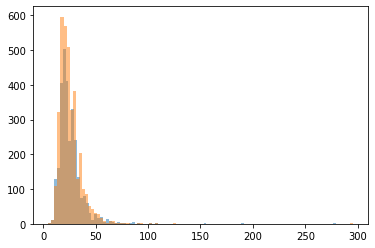

In [62]:

plt.hist(x1, alpha=.5, bins=100);
plt.hist(x2, alpha=.5, bins=100);